In [139]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import test_result
from utils.mean_variance import *
import os

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A test for the risk-budgeting model

## Data/Stock choosing:
1. 2010-2022年中一直在上证300中的股票-52只
2. Monthly period from 2010 - 2022. 


In [140]:
crt_dir = os.path.abspath("")
data_dir = os.path.abspath("data")


Read in monthly return rates the 52 stocks and risk free rates from 2009-12 to 2022-12.

In [141]:
R_df = pd.read_csv(os.path.join(
    data_dir, "Monthly_Return_Rates.csv"), index_col=0, parse_dates=True)
R_df = R_df.fillna(0)
rf_df = pd.read_csv(os.path.join(
    data_dir, "Monthly_rf_Rates.csv"), index_col=0, parse_dates=True)
rf_df = rf_df.fillna(0)
rf_df = rf_df


Compute monthly **excess** return rates:

In [142]:
from utils import data_prep
R_excess_df = data_prep.get_excess_return_rates(R_df, rf_df)


CSI300 monthly return:

In [143]:
CSI300_df = pd.read_csv(os.path.join(
    data_dir, "000300.csv"), index_col=1, parse_dates=True)['Idxrtn']


# Construct Portfolio

* Consider the optimization problem: 

\begin{aligned}
\min_{w} & \quad \sum_{i=1}^N RC_i(w)\\
\textrm{s.t.} & \quad  \boldsymbol{1}^Tw \leq 1.5\\
                   & \quad w  \geq \boldsymbol{0}\\
\end{aligned}


* Following the logic from sta4020 asg7. Starting from the end of 2015, at the end of every month, use the historical asset returns (from 2011/1 to the end of that month).

**Estimated Excess Return after 2017; And corresponding portfolio.**

**Please note that there are clear descriptions for the functions and constraint, please remember to check before implementing the models**

To add other constraints, please refer to `cons_*()` in `mean_variance.py`. For example, we implemented the box constraints for $RC_i(w)$: $$\boldsymbol{L} \leq RC(w) \leq \boldsymbol{U}.$$

You can add the box constraints by adding `cons_sum_weight_lower_bound(L)` and `cons_sum_weight_upper_bound(U)` to the `constraint_list`. Note that L and U are N-dimension vector, given N assets.

In [144]:
constraint_list = [
    cons_non_negative_weight(), cons_sum_weight_upper_bound(1.5)]
    
R_excess_hat, w_hat = portfolio_construction(
    2, 25, R_excess_df, objective=obj_Exp_minus_RC, constraints=constraint_list)


**Compute net excess return; and recover net return by adding risk-free return.**

In [145]:
R_net_hat = np.sum(R_excess_hat, axis=1) + \
    rf_df[rf_df.index >= pd.Timestamp("2017")].values.reshape(-1,)
R_net_hat_df = pd.DataFrame(R_net_hat, columns=[
                            'return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index)


test_result.calculate_result(
    R_net_hat_df, rf_df[rf_df.index >= pd.Timestamp("2017")])


,accu_return,annual_return,annual_vol,sharpe_ratio,max_dd,winning_rate,karmar
0,1.198912,0.142452,3.837313,0.034517,-0.55514,0.549296,2.159656


#### Todo: Momentum 调参

In [146]:
# constraint_list = [cons_non_negative_weight(), cons_sum_weight_upper_bound(1.5)]

# for i in range(20):#i is the 52-i stock we decide to keep according to momentum
#     for j in range(-6,-2):#j is the momentum period we consider
#         print(portfolio_construction(j,i,p_dates,data))


(以上回测的结果是动量period3个月效果比较显著,在无论哪个rank的情况下 （这里之后可以画图））

In [147]:
# sp = []
# ar =[]
# for i in range(10,35):
#     df = portfolio_construction(-4,i,p_dates,data,constraint="1+2+3")
#     sp.append( df['sharpe_ratio'].values)
#     ar.append(df['accu_return'].values)


In [148]:
# sp = np.array(sp)
# ar = np.array(ar)
# sp[sp.argmax()],ar[ar.argmax()],sp.argmax(),ar.argmax()


**Construct equal weighted portfolio**

In [149]:
ew_rets = pd.DataFrame(np.sum(
    1.0*R_df[R_df.index >= pd.Timestamp("2017")]/R_df.shape[1], axis=1), columns=['return'])


**Plot the portfolio cumulative returns**

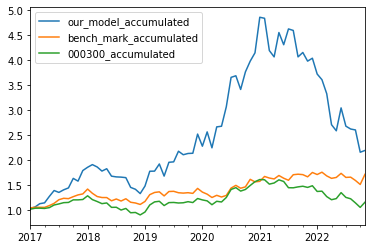

In [150]:
p_cum = ((R_net_hat_df['return'] + 1).cumprod())
ew_cum = (ew_rets['return'] + 1).cumprod()
CSI300_cumrets = (CSI300_df[CSI300_df.index.year >= 2017] + 1).cumprod()

pd.concat([p_cum, ew_cum, CSI300_cumrets], axis=1).plot()
plt.legend(['our_model_accumulated',
           'bench_mark_accumulated', '000300_accumulated'])
plt.show()


* maximize the sharp ratio and the formula derivation: this repository may helps

https://github.com/PaiViji/PythonFinance--RiskBudgeted-Portfolio-Construction.git

* we can also use this repository to check the quality of our work:

https://github.com/jcrichard/pyrb.git